In [1]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()

dataframe.shape

(3104, 204)

In [2]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know those values.
data_leak_list = ["co2", "ghg", "greenhouse_gas",  "change"]
possible_data_leak_list = ["nitrous_oxide", "methane", "ch4", "n2o", "methane"]
to_exclude = data_leak_list + possible_data_leak_list

def is_data_leak(s, to_exclude):
    for data_leak in to_exclude:
        if data_leak in s:
            return True

    return False

feature_list = []
for x in numeric_cols:
    is_leak = is_data_leak(x, to_exclude)
    if not is_leak:
        feature_list.append(x)


print(feature_list)

['agricultural_land_area_in_hectares', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_per_capita', 'coal_production', 'coal_share_elec', 'coal_share_energy', 'cropland_area_in_hectares', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_per_capita', 'energy_per_gdp', 'forest_land_area_in_hectares', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_fuel_consumption', 'fossil_share_elec', 'fossil_share_energy', 'gas_consumption', 'gas_elec_per_capita', 'gas_electricity', 'gas_energy_per_capita', 'gas_prod_per_capita', 'gas_production', 'gas_share_elec', 'gas_share_energy', 'gdp', 'hydro_consumption', 'hydro_elec_per_capita', 'hydro_electricity', 'hydro_energy_per_capita', 'hydro_share_elec', 'hydro_sha

In [3]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2'].sort_values(ascending=False) #Reduced feature list to 97, need to check if any of these are unrelated. 

co2                           1.000000
fossil_fuel_consumption       0.992006
fossil_electricity            0.990423
primary_energy_consumption    0.987311
electricity_generation        0.979749
                                ...   
hydro_share_elec             -0.112958
renewables_share_elec        -0.115668
oil_share_elec               -0.146162
nuclear_share_energy         -0.164512
oil_share_energy             -0.173952
Name: co2, Length: 98, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ('std_scalar', StandardScaler())])
# test if I can hand-pick a few features avoiding most of the repeats.
X = dataframe[feature_list]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Training Model for features with no data leaks

In [37]:
X_train_no_data_leaks = data_pipeline.fit_transform(X_train)
X_test_no_data_leaks = data_pipeline.transform(X_test)
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models_no_data_leaks = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train_no_data_leaks, y_train) for x in models_no_data_leaks ] #train features with data leak features removed

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def adjusted_r2(r2_score, sample_size, num_features):
    return 1-(1-r2_score)*(sample_size-1)/(sample_size-num_features-1)

## Checking scores for models with data leak features removed.

In [9]:
training_predictions = [m.predict(X_train_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Train data scores
 LinearRegression: Mean Squared Error: 293.3450868114917, R2_score 0.9994252197149857, Adjusted R2 score: 0.9994018429067482, Mean absolute Percentage Error: 154.58624479560717%
 Ridge: Mean Squared Error: 330.26517760537905, R2_score 0.9993528784989116, Adjusted R2 score: 0.9993265595112364, Mean absolute Percentage Error: 119.23591439836918%
 Lasso: Mean Squared Error: 475.237121457683, R2_score 0.9990688205107168, Adjusted R2 score: 0.9990309486405027, Mean absolute Percentage Error: 132.57968085450838%
 DecisionTreeRegressor: Mean Squared Error: 3.723102590841213e-36, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 1.927283154112025e-17%
 RandomForestRegressor: Mean Squared Error: 181.94529825442922, R2_score 0.9996434964310313, Adjusted R2 score: 0.9996289971244527, Mean absolute Percentage Error: 3.0631118090400196%
 SGDRegressor: Mean Squared Error: 737.0418606492949, R2_score 0.9985558403744332, Adjusted R2 score: 0.9984971051611502, Mean

[None, None, None, None, None, None]

In [10]:
predictions = [m.predict(X_test_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Test data scores
 LinearRegression: Mean Squared Error: 387.87586323742573, R2_score 0.9996357955182322, Adjusted R2 score: 0.999568247077063, Mean absolute Percentage Error: 175.52189173320428%
 Ridge: Mean Squared Error: 397.551148813433, R2_score 0.9996267106983114, Adjusted R2 score: 0.9995574773096617, Mean absolute Percentage Error: 124.73808263279724%
 Lasso: Mean Squared Error: 509.6192041190474, R2_score 0.9995214819592385, Adjusted R2 score: 0.9994327319593267, Mean absolute Percentage Error: 143.62780487598806%
 DecisionTreeRegressor: Mean Squared Error: 4740.929393383253, R2_score 0.9955484011858773, Adjusted R2 score: 0.9947227700482675, Mean absolute Percentage Error: 11.580423769746458%
 RandomForestRegressor: Mean Squared Error: 852.9478005482183, R2_score 0.9991991061029661, Adjusted R2 score: 0.9990505655522735, Mean absolute Percentage Error: 7.786783256061529%
 SGDRegressor: Mean Squared Error: 828.1865402256008, R2_score 0.9992223562271385, Adjusted R2 score: 0.999

[None, None, None, None, None, None]

In [13]:
#random forest has the lowest accuracy error and a decent r2 score.
random_forest_preds = predictions[4]

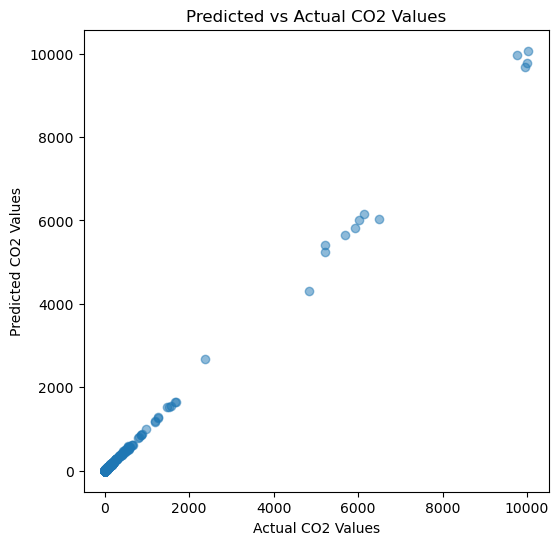

In [14]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, random_forest_preds, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

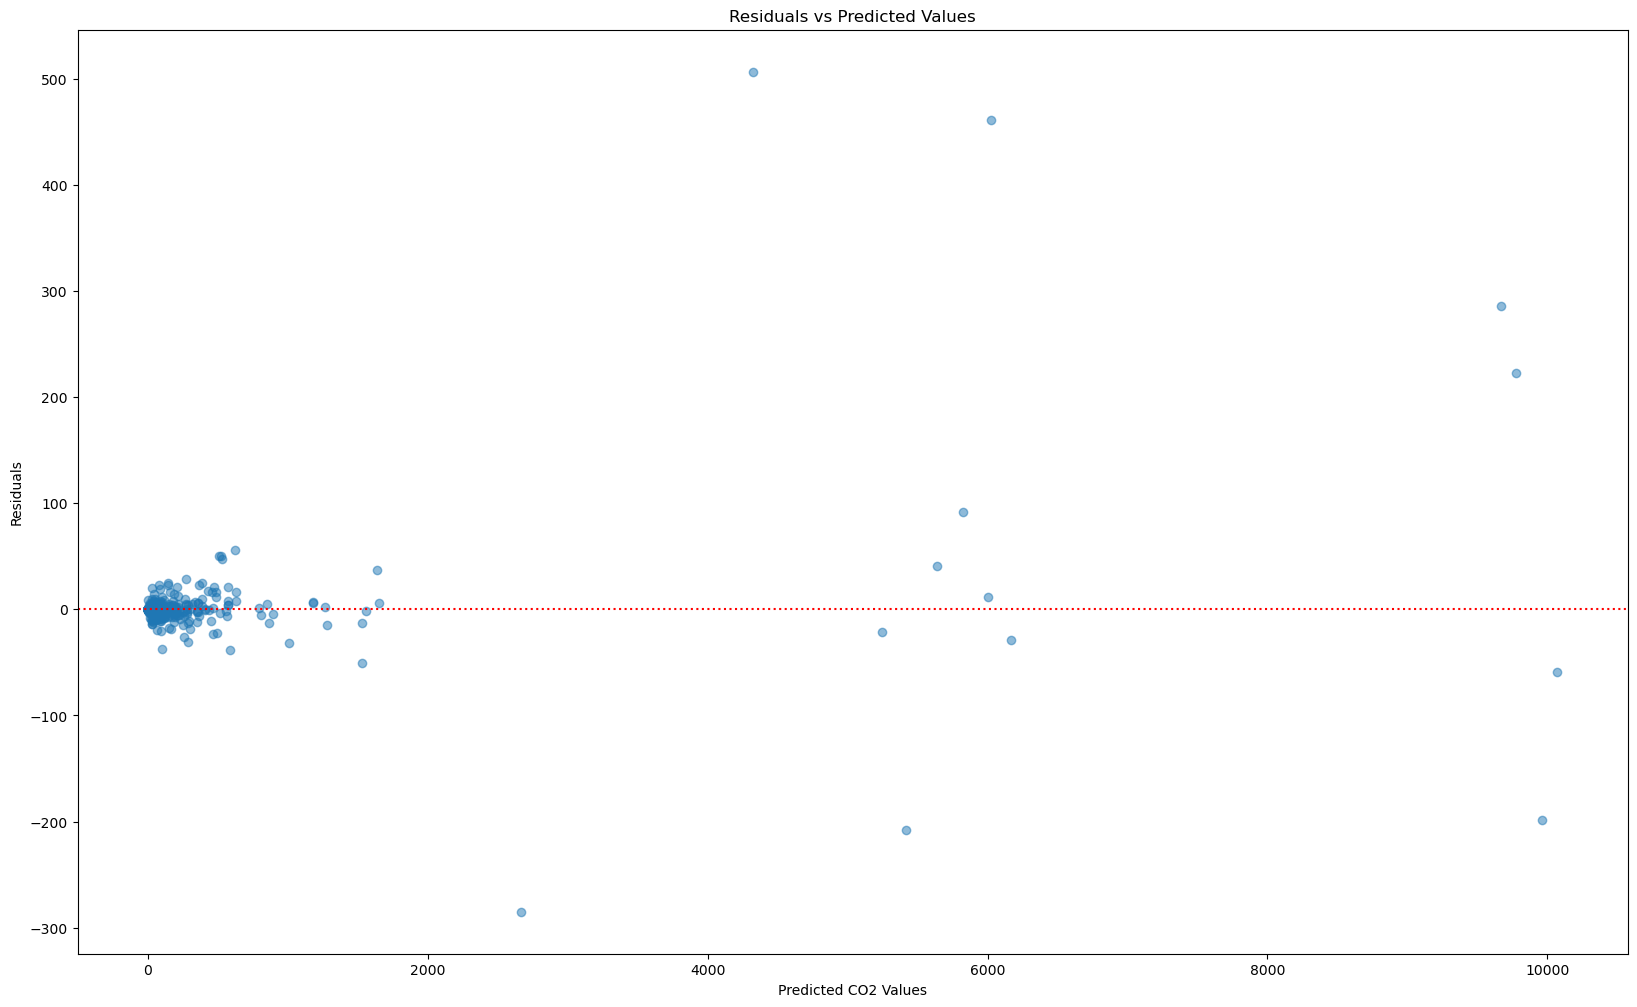

In [15]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = random_forest_preds

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(20, 12))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()

<Axes: >

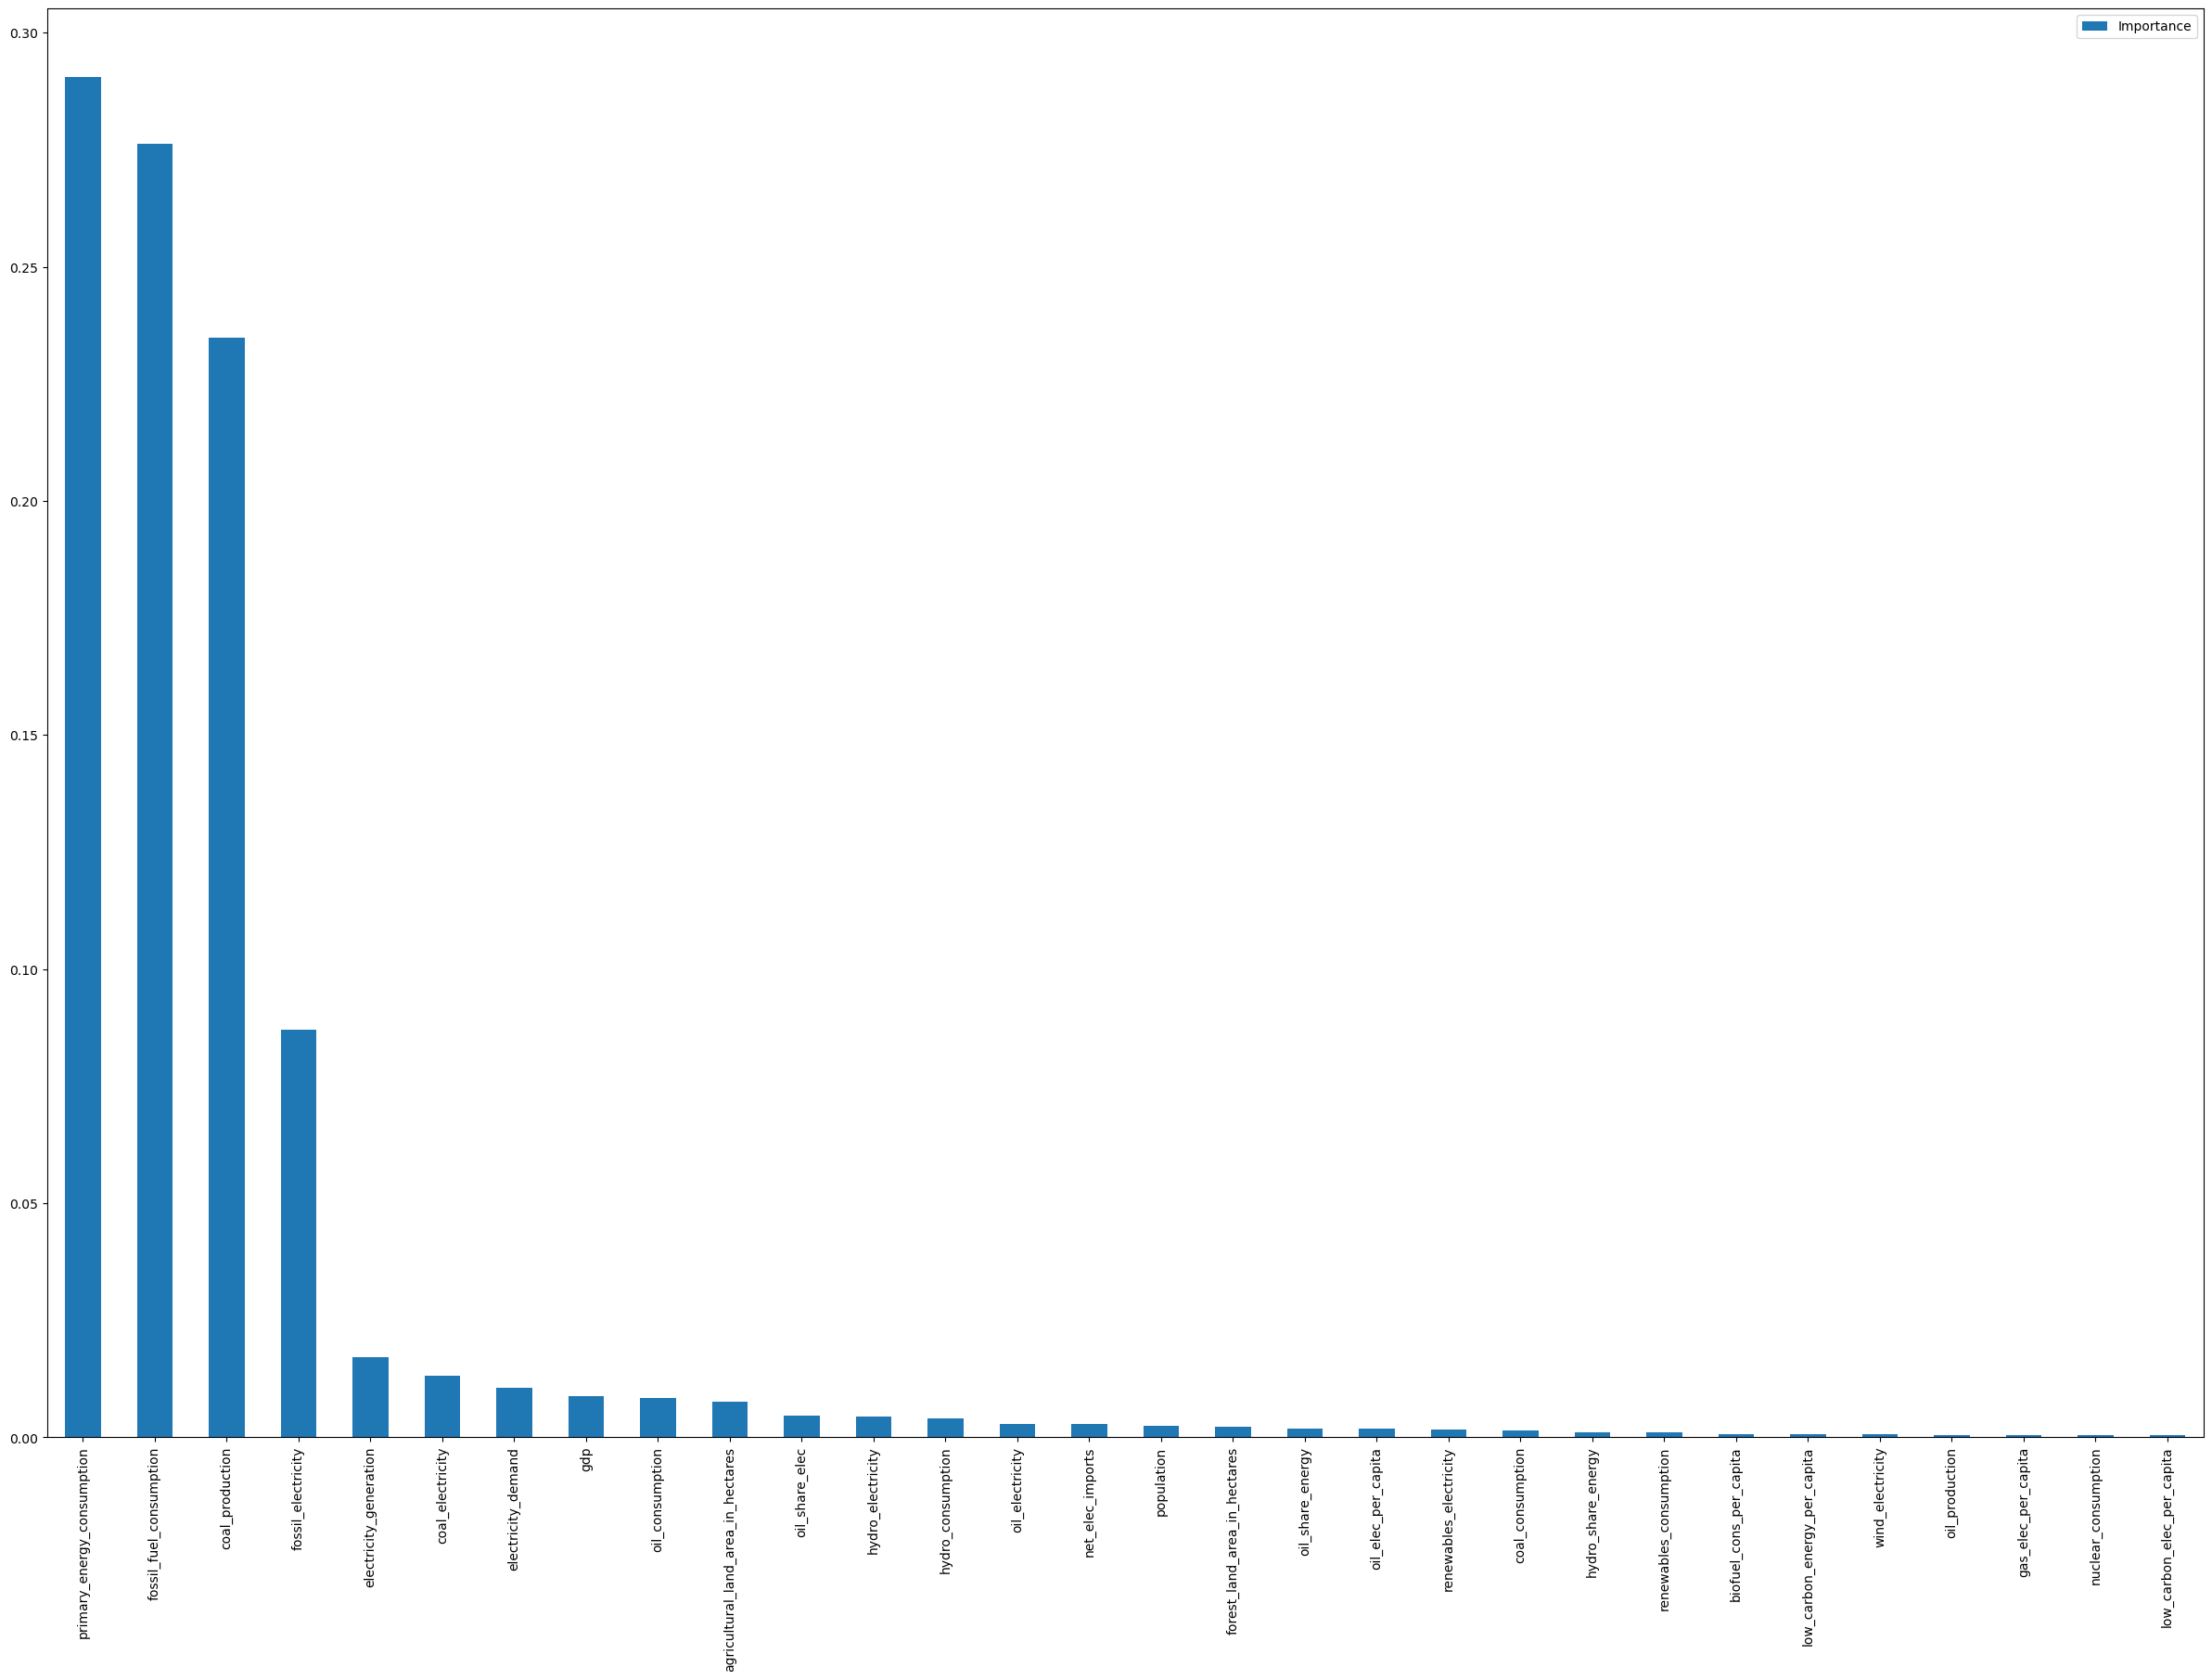

In [22]:
import pandas as pd
model = models_no_data_leaks[4]
importance_df = pd.DataFrame(model.feature_importances_, index=feature_list, columns=["Importance"])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df.head(30).plot(kind='bar', figsize=(30,20))

In [49]:
selected_features = importance_df.head(20).index.tolist()
print(selected_features)

X = dataframe[selected_features]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = data_pipeline.fit_transform(X_train)
X_test = data_pipeline.transform(X_test)

['primary_energy_consumption', 'fossil_fuel_consumption', 'coal_production', 'fossil_electricity', 'electricity_generation', 'coal_electricity', 'electricity_demand', 'gdp', 'oil_consumption', 'agricultural_land_area_in_hectares', 'oil_share_elec', 'hydro_electricity', 'hydro_consumption', 'oil_electricity', 'net_elec_imports', 'population', 'forest_land_area_in_hectares', 'oil_share_energy', 'oil_elec_per_capita', 'renewables_electricity']


In [50]:
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train, y_train) for x in models ]

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [51]:
training_predictions = [m.predict(X_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 493.6024407390278, R2_score 0.9990328355090056, Adjusted R2 score: 0.9990249787706547, Mean absolute Percentage Error: 100.4208144034894%
 Ridge: Mean Squared Error: 510.42766455813575, R2_score 0.998999868169933, Adjusted R2 score: 0.9989917436221665, Mean absolute Percentage Error: 84.78246079740993%
 Lasso: Mean Squared Error: 829.924004836484, R2_score 0.9983738471258368, Adjusted R2 score: 0.9983606371106121, Mean absolute Percentage Error: 211.10278589721014%
 DecisionTreeRegressor: Mean Squared Error: 3.723102590841213e-36, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 1.927283154112025e-17%
 RandomForestRegressor: Mean Squared Error: 203.7758210206624, R2_score 0.9996007217105342, Adjusted R2 score: 0.9995974781825937, Mean absolute Percentage Error: 3.1313331556246995%
 SGDRegressor: Mean Squared Error: 1864.4579528963732, R2_score 0.9963467815833856, Adjusted R2 score: 0.9963171047481573, Mean ab

[None, None, None, None, None, None]

In [52]:
predictions = [m.predict(X_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y) for y in predictions]
r2_scores = [r2_score(y_test, y) for y in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100} %") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 502.52307092539735, R2_score 0.9995281450279089, Adjusted R2 score: 0.9995124165288392, Mean absolute Percentage Error: 112.74371072415687 %
 Ridge: Mean Squared Error: 507.66062486988375, R2_score 0.9995233210098422, Adjusted R2 score: 0.9995074317101703, Mean absolute Percentage Error: 87.27030645932169 %
 Lasso: Mean Squared Error: 734.5561565273746, R2_score 0.9993102725132613, Adjusted R2 score: 0.9992872815970367, Mean absolute Percentage Error: 244.41900947414464 %
 DecisionTreeRegressor: Mean Squared Error: 2435.425063611915, R2_score 0.9977132046429144, Adjusted R2 score: 0.9976369781310115, Mean absolute Percentage Error: 9.75661287976877 %
 RandomForestRegressor: Mean Squared Error: 1464.650425205085, R2_score 0.9986247346132074, Adjusted R2 score: 0.9985788924336477, Mean absolute Percentage Error: 8.02848763251307 %
 SGDRegressor: Mean Squared Error: 2799.4691106244863, R2_score 0.9973713775635591, Adjusted R2 score:

[None, None, None, None, None, None]